** Objectives **

* Create a model based on initial data exploration.
* Find ways to extend this model to capture interaction in the data.

In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

sns.set_style('whitegrid')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/See_Click_Predict/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(0)

In [3]:
# load files
train = pd.read_csv(os.path.join(basepath, 'data/raw/train.csv'), parse_dates=['created_time'])
test = pd.read_csv(os.path.join(basepath,  'data/raw/test.csv'), parse_dates=['created_time'])
sample_sub = pd.read_csv(os.path.join(basepath, 'data/raw/sampleSubmission.csv'))

In [138]:
class Data:
    def __init__(self, train, test):
        self.train = train
        self.test = test
    
    def concat_data(self):
        self.data = pd.concat((self.train, self.test), axis=0)
        return self.data
    
    def round_location(self):
        self.data['latitude'] = self.data.latitude.map(np.round)
        self.data['longitude'] = self.data.longitude.map(np.round)
        
        return self.data
    
    def fill_missing_values(self, feature, value):
        self.data[feature] = self.data[feature].fillna(value)
        
        return self.data
        
    def encode_categorical_variable(self, feature):
        lbl = LabelEncoder()
        
        lbl.fit(self.data[feature])
        self.data[feature] = lbl.transform(self.data[feature])
        
        return self.data
        
    def get_train_test(self):
        mask = self.data.num_votes.notnull()
        
        train = self.data.loc[mask]
        test = self.data.loc[~mask]
        
        return train, test
    
    def one_hot_encode(self, feature):
        ohe = pd.get_dummies(self.data[feature])
        self.data = pd.concat((self.data, ohe), axis=1)
        
        return self.data
    
    def decompose_date(self):
        self.data['month'] = self.data.created_time.dt.month
        self.data['year'] = self.data.created_time.dt.year
        self.data['week'] = self.data.created_time.dt.dayofweek
        
        return self.data

In [139]:
d = Data(train, test)
d.concat_data()
d.round_location()
d.fill_missing_values('source', 'not_known_source')
d.fill_missing_values('tag_type', 'not_known_tag')
d.one_hot_encode('source')
d.one_hot_encode('tag_type')
d.one_hot_encode('latitude')
d.one_hot_encode('longitude')
_ = d.decompose_date()

In [140]:
train_, test_ = d.get_train_test()

In [141]:
assert len(train) == len(train_)
assert len(test) == len(test_)

** Model **

In [144]:
features = train_.columns[11:]

X = train_[features]
y_votes = train_.num_votes
y_views = train_.num_views
y_comments = train_.num_comments

Xtest = test_[features]

** Train Test Split. **

* Split in such a way that we preserve the temporal element.

In [161]:
train_.created_time.max()

Timestamp('2013-04-30 23:51:37')

In [177]:
def get_start_end_date():
    start_date = '2012-08-01'
    end_date = '2013-02-28'
    
    return start_date, end_date

start_date, end_date = get_start_end_date()

** Training examples contain data from 2012 and rest should be from 2013. **

In [178]:
mask_train = (train.created_time >= start_date) & (train.created_time <= end_date)
mask_test = (train.created_time > end_date)

X_train = X.loc[mask_train]
X_test = X.loc[mask_test]

y_train_votes = y_votes.loc[mask_train]
y_test_votes =  y_votes.loc[mask_test]

y_train_views = y_views.loc[mask_train]
y_test_views = y_views.loc[mask_test]

y_train_comments = y_comments.loc[mask_train]
y_test_comments = y_comments.loc[mask_test]

In [179]:
print(X_train.shape, X_test.shape)

(161823, 65) (34813, 65)


In [180]:
est_1 = RandomForestRegressor(n_estimators=50, max_features='sqrt', n_jobs=2)
est_2 = RandomForestRegressor(n_estimators=50, max_features='sqrt', n_jobs=2)
est_3 = RandomForestRegressor(n_estimators=50, max_features='sqrt', n_jobs=2)

est_1.fit(X_train, y_train_votes)
est_2.fit(X_train, y_train_views)
est_3.fit(X_train, y_train_comments)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [181]:
y_preds_votes = est_1.predict(X_test)
y_preds_views = est_2.predict(X_test)
y_preds_comments = est_3.predict(X_test)

In [182]:
def rmsle(ytvotes, ytviews, ytcomments, ypvotes, ypviews, ypcomments):
    s = 0 
    
    dvotes = (np.log(ytvotes + 1) - np.log(ypvotes + 1)) ** 2
    dviews = (np.log(ytviews + 1) - np.log(ypviews + 1)) ** 2
    dcomments = (np.log(ytcomments + 1) - np.log(ypcomments + 1)) ** 2
      
    s = np.sum(dvotes) + np.sum(dviews) + np.sum(dcomments)
    return np.sqrt(1 / (3*len(ytvotes)) * s)


In [183]:
print('RMSLE on the test set: %f'%(rmsle(y_test_votes.values, y_test_views.values, y_test_comments.values, y_preds_votes,\
                                         y_preds_views, y_preds_comments)))

RMSLE on the test set: 0.499108


** Feature Importance. **

In [188]:
def get_feature_importances(forest, X, classifier_name):
    print('=========== Feature Importance for %s\n'%classifier_name)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show();

=========== Feature Importance for Votes Estimator

Feature ranking:
1. feature 7 (0.381698)
2. feature 64 (0.157853)
3. feature 62 (0.131295)
4. feature 5 (0.040683)
5. feature 25 (0.027132)
6. feature 56 (0.025164)
7. feature 60 (0.021880)
8. feature 29 (0.021590)
9. feature 4 (0.019535)
10. feature 6 (0.016451)
11. feature 35 (0.014692)
12. feature 63 (0.012363)
13. feature 61 (0.010125)
14. feature 58 (0.007658)
15. feature 3 (0.007480)
16. feature 57 (0.007234)
17. feature 44 (0.007068)
18. feature 55 (0.006701)
19. feature 49 (0.006264)
20. feature 8 (0.005900)
21. feature 50 (0.005833)
22. feature 46 (0.005751)
23. feature 43 (0.004871)
24. feature 22 (0.004396)
25. feature 59 (0.004229)
26. feature 1 (0.004132)
27. feature 2 (0.004010)
28. feature 14 (0.003527)
29. feature 51 (0.003503)
30. feature 18 (0.003084)
31. feature 16 (0.003046)
32. feature 54 (0.002643)
33. feature 45 (0.002234)
34. feature 24 (0.002198)
35. feature 0 (0.002131)
36. feature 33 (0.001583)
37. feature 3

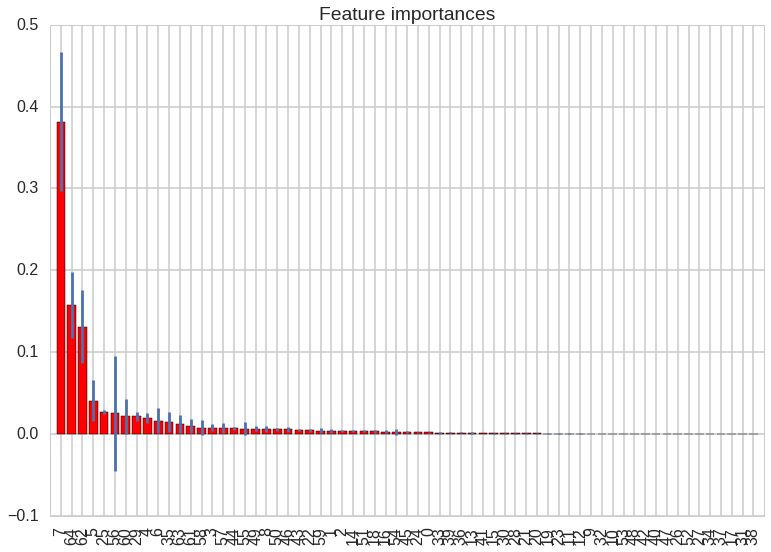

In [189]:
# Build a forest and compute the feature importances
votes_est = RandomForestRegressor(n_estimators=25, random_state=1)
votes_est.fit(X_train, y_train_votes)

get_feature_importances(votes_est, X_train, 'Votes Estimator')

In [193]:
X_train.columns[7]

'remote_api_created'

** Model Fit **

In [149]:
# fit on the whole set
est_1.fit(X, y_votes)
est_2.fit(X, y_views)
est_3.fit(X, y_comments)

KeyboardInterrupt: 

In [74]:
ypred_views = est_1.predict(Xtest)
ypred_votes = est_2.predict(Xtest)
ypred_comments = est_3.predict(Xtest)

In [75]:
sample_sub['num_views'] = ypred_views
sample_sub['num_votes'] = ypred_votes
sample_sub['num_comments'] = ypred_comments

In [77]:
sample_sub.to_csv(os.path.join(basepath, 'submissions/benchmark_model.csv'), index=False)